# Assignment 1 - Blending

Name: Nalet Meinen<br>
Matriculation number: 13-463-955

CAUTION: This was made with Pyhton 3.8

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy import sparse
from scipy.signal import convolve2d
from hessian_matrix import hessian_matrix

In [2]:
# This part is for displaying a status bar.
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

Text(0.5, 1.0, 'Foreground')

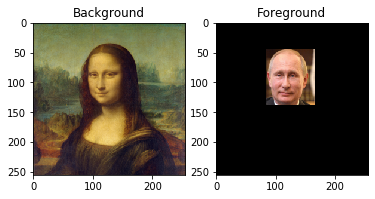

In [3]:
b = array(Image.open('monalisa.png')) / 256
f = array(Image.open('putin.jpg')) / 256
#b = array(Image.open('queen.png')) / 256
#f = array(Image.open('trump.jpg')) / 256

# head location of Mona and Putin
m = [83, 45, 166, 139]
p = [285, 1, 585, 307]

# align foreground
f2 = zeros((256, 256, 3))
tmp = resize(f[p[1]:p[3], p[0]:p[2], :], (m[3] - m[1], m[2] - m[0]))
f2[m[1]:m[3], m[0]:m[2], :] = tmp

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.title('Background')
plt.subplot(1, 2, 2)
plt.imshow(f2)
plt.title('Foreground')

Text(0.5, 1.0, 'Mask')

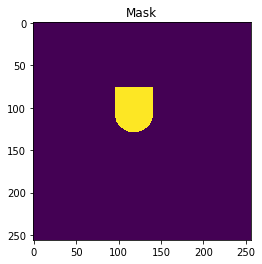

In [4]:
# apply mask
c = [118, 106]
r = 23
bb = [96, 76, 141, 109]
x, y = meshgrid(arange(256), arange(256))
omega = ((x - c[0]) ** 2 + (y - c[1]) ** 2) < r ** 2      
omega[bb[1]:bb[3], bb[0]:bb[2]] = True

plt.figure()
plt.imshow(omega)
plt.title('Mask')

In [5]:
def energy(u, b, f, omega, lmbda):

    m, n, l = b.shape
    sum1 = zeros(l)
    sum2 = zeros(l)

    for i in range(l):
        sum1[i] = sum(sum((1-omega) * (u[:, :, i]-b[:, :, i]) ** 2))

    for i in range(1, m-1):
        for j in range(1, n-1):
            for k in range(l):
                sum2[k] = sum2[k] + omega[i, j] * \
                    (2*u[i, j, k]-u[i+1, j, k]-u[i, j+1, k]-2 *
                     f[i, j, k]+f[i-1, j, k]+f[i, j-1, k]) ** 2

    return sum(sum1 + lmbda*sum2)


def GD_energy(u, b, f, omega, lmbda):

    m, n, l = b.shape
    grad = zeros((m, n, l))
    
    #approx kernel for convolution
    kernel = array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

    for k in arange(0, l):
        grad[:, :, k] = 2 * (1-omega) * (u[:, :, k]-b[:, :, k]) + 2 * lmbda * omega * (
            convolve2d(u[:, :, k], kernel, 'same')-convolve2d(f[:, :, k], kernel, 'same'))

    return grad

## (a) Gradient Descent

In [6]:
def GD(f, b, omega, lmbda):
    """
    b: backgound color image of size (M, N, 3)
    f: foreground color image of size (M, N, 3)
    omega: foreground mask of size (M, N)
    lmbda: parameter

    :returns u: blended image of size (M, N, 3)
    """

    m, n, l = b.shape
    u = b.copy()
    s_u = []

    eps = 0.05  # step size
    err_E = iinfo(int32).max  # error which determines when to stop
    grad_E = zeros((m, n, l))
    E = []  # value of the energy function

    while err_E > 0.01:  # until the gradient is close enough to zero
        grad_E = GD_energy(u, b, f, omega, lmbda)
        clear_output(wait = True)
        print("Iteration:",len(E))
        if len(E) == 40 or len(E) == 80 or len(E) == 120:
            s_u.append((u.copy(),len(E)))
            clip(s_u[-1][0], 0, 255, s_u[-1][0])
            
        err_E = max(grad_E.flatten('F'))
        E.append(energy(u, b, f, omega, lmbda))

        for k in arange(0, l):
            u[:, :, k] = u[:, :, k] - eps * grad_E[:, :, k]

    clip(u, 0, 255, u)

    return u, E, s_u

Iteration: 183


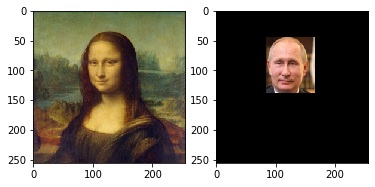

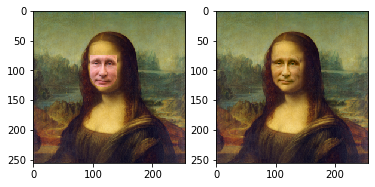

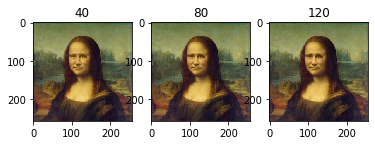

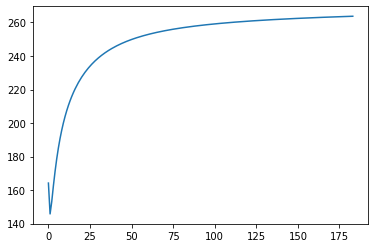

In [7]:
# blend
lmbda = 2#/100  # change
u, E, s_u = GD(f2, b, omega, lmbda)

# display
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.subplot(1, 2, 2)
plt.imshow(f2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(expand_dims(omega, 2) * f2 + expand_dims(1 - omega, 2) * b)
plt.subplot(1, 2, 2)
plt.imshow(u)

plt.figure()
plt.subplot(1, 3, 1).set_title(s_u[0][1])
plt.imshow(s_u[0][0])
plt.subplot(1, 3, 2).set_title(s_u[1][1])
plt.imshow(s_u[1][0])
plt.subplot(1, 3, 3).set_title(s_u[2][1])
plt.imshow(s_u[2][0])

plt.figure()
plt.plot(E)

## (b) Linearization + Gauss-Seidel

In [8]:
def gauss_seidel(A, u, grad_E):
    c = A @ u - grad_E
    L = tril(A)
    U = triu(A, 1)
    A_ = L
    B_ = c - U @ u
    return linalg.solve(A_, B_)

In [9]:
def LGS(f, b, omega, lmbda):
    """
    b: backgound color image of size (M, N, 3)
    f: foreground color image of size (M, N, 3)
    omega: foreground mask of size (M, N)
    lmbda: parameter

    :returns u: blended image of size (M, N, 3)
    """
    u = b.copy()
    s_u = []
    m, n, l = b.shape
    A = zeros((m, n, l))
    n_iterations = 200
    E = []

    for s in range(n_iterations):

        grad_E = GD_energy(u, b, f, omega, lmbda)
        E.append(energy(u, b, f, omega, lmbda))
        update_progress(s / n_iterations)
        
        if len(E) == round(n_iterations/4) or len(E) == round((n_iterations/4)*2) or len(E) == round((n_iterations/4)*3):
            s_u.append((u.copy(),len(E)))
            clip(s_u[-1][0], 0, 255, s_u[-1][0])

        for i in range(l):
            t = u[:, :, i]
            t_ = sparse.csr_matrix(t.flatten('F'))

            #temporary fix for hessian matrix with custom coefficients
            ht1 = reshape(t_ * hessian_matrix(t, [2, 0, 0, 0, 0], lmbda),
                          (m, n), order="F").toarray()            
            ht2 = reshape(t_ * hessian_matrix(t, [8, -2, -2, -2, -2], lmbda),
                          (m, n), order="F").toarray()

            background = ht1 @ (1-omega)
            foreground = ht2 @ omega
            A[:, :, i] = background + foreground

            u[:, :, i] = gauss_seidel(A[:, :, i], u[:, :, i], grad_E[:, :, i])

    clip(u, 0, 255, u)
    update_progress(1)
    return u, E, s_u

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Progress: [####################] 100.0%


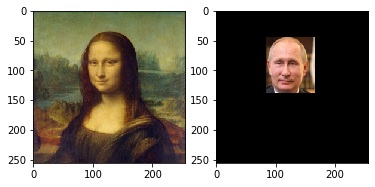

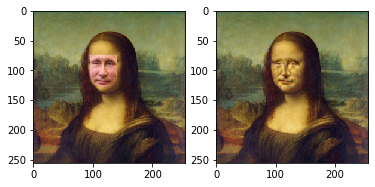

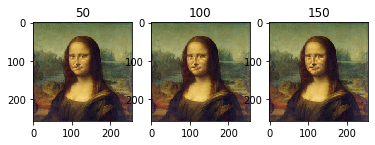

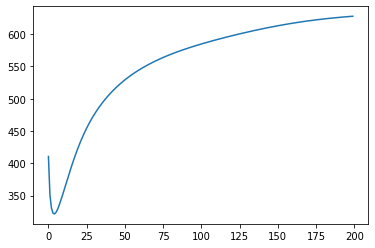

In [10]:
# blend
lmbda = 5#/100  # change 
u, E, s_u = LGS(f2, b, omega, lmbda)

# display
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.subplot(1, 2, 2)
plt.imshow(f2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(expand_dims(omega, 2) * f2 + expand_dims(1 - omega, 2) * b)
plt.subplot(1, 2, 2)
plt.imshow(u)

plt.figure()
plt.subplot(1, 3, 1).set_title(s_u[0][1])
plt.imshow(s_u[0][0])
plt.subplot(1, 3, 2).set_title(s_u[1][1])
plt.imshow(s_u[1][0])
plt.subplot(1, 3, 3).set_title(s_u[2][1])
plt.imshow(s_u[2][0])

plt.figure()
plt.plot(E)

## (c) Linearization + SOR

In [11]:
def LSOR(f, b, omega, lmbda):
    """
    b: backgound color image of size (M, N, 3)
    f: foreground color image of size (M, N, 3)
    omega: foreground mask of size (M, N)
    lmbda: parameter

    :returns u: blended image of size (M, N, 3)
    """

    u = b.copy()
    s_u = []
    m, n, l = b.shape
    A = zeros((m, n, l))
    c = zeros((m, n, l))
    n_iterations = 200
    E = []

    for s in range(n_iterations):
        grad_E = GD_energy(u, b, f, omega, lmbda)
        E.append(energy(u, b, f, omega, lmbda))
        update_progress(s / n_iterations)
        if len(E) == round(n_iterations/4) or len(E) == round((n_iterations/4)*2) or len(E) == round((n_iterations/4)*3):
            s_u.append((u.copy(),len(E)))
            clip(s_u[-1][0], 0, 255, s_u[-1][0])
        
        for i in range(l):
            t = u[:, :, i]
            t_ = sparse.csr_matrix(t.flatten('F'))
            
            #temporary fix for hessian matrix with custom coefficients
            ht1 = reshape(t_ * hessian_matrix(t, [2, 0, 0, 0, 0], lmbda),
                          (m, n), order="F").toarray()
            ht2 = reshape(t_ * hessian_matrix(t, [8, -2, -2, -2, -2], lmbda),
                          (m, n), order="F").toarray()

            background = ht1 @ (1-omega)
            foreground = ht2 @ omega

            A[:, :, i] = background + lmbda * foreground
            c[:, :, i] = A[:, :, i] @ u[:, :, i] - grad_E[:, :, i]

            L = tril(A[:, :, i], -1)
            U = triu(A[:, :, i], 1)
            d = diag(A[:, :, i])
            D = diag(d)

            A_ = D+L
            B_ = c[:, :, i] - U @ u[:, :, i]
            u[:, :, i] = linalg.solve(A_, B_)
    clip(u, 0, 255, u)
    update_progress(1)
    return u, E, s_u

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Progress: [####################] 100.0%


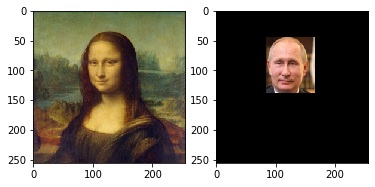

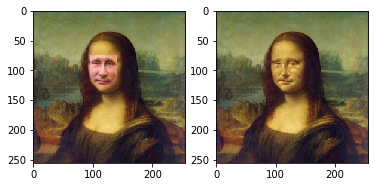

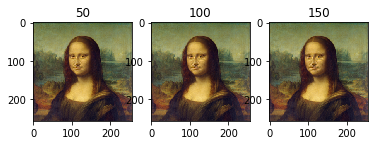

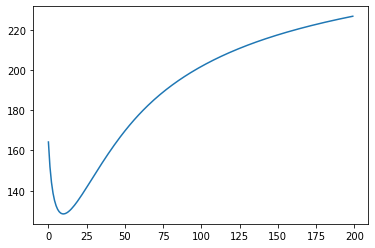

In [12]:
# blend
lmbda = 2#/100  # change 
u, E, s_u = LSOR(f2, b, omega, lmbda)

# display
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.subplot(1, 2, 2)
plt.imshow(f2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(expand_dims(omega, 2) * f2 + expand_dims(1 - omega, 2) * b)
plt.subplot(1, 2, 2)
plt.imshow(u)

plt.figure()
plt.subplot(1, 3, 1).set_title(s_u[0][1])
plt.imshow(s_u[0][0])
plt.subplot(1, 3, 2).set_title(s_u[1][1])
plt.imshow(s_u[1][0])
plt.subplot(1, 3, 3).set_title(s_u[2][1])
plt.imshow(s_u[2][0])

plt.figure()
plt.plot(E)